## Residue analysis

 - per-residue analysis (heatmap)
 - protein coloring script

Total # mutations: 480
Total # mutations (singles only): 327


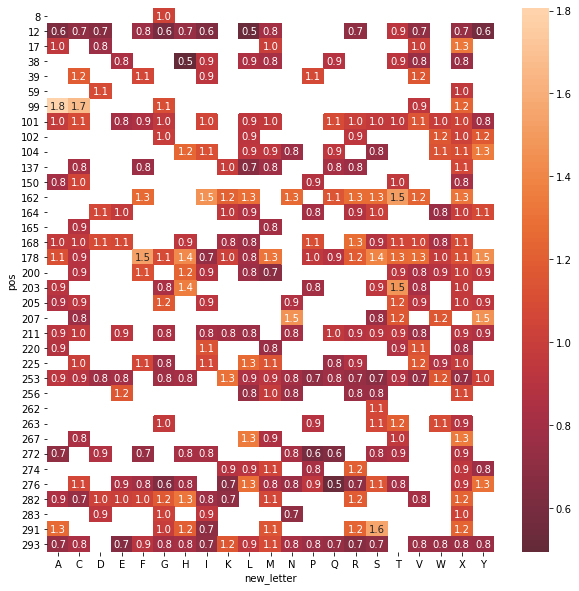

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import import_igaba_pkl


# import dataframe generated by ingest-igabasnfr-csv.ipynb
nAP=40
data = import_igaba_pkl(nAP, 'responsivepx-segmented-csvs') # 'ilastik-segmented-csvs' or 'responsivepx-segmented-csvs'

# which variable to plot on heatmap
var_to_plot = 'SNR_norm'
print('Total # mutations: ' + str(data.shape[0]))
df_singles = data[data['is_combo_int'] == 0].copy()

# convert position to single number and letter to single str
df_singles['pos'] = [p[0] for p in df_singles['pos']]
df_singles['orig_letter'] = [p[0] for p in df_singles['orig_letter']]
df_singles['new_letter'] = [p[0] for p in df_singles['new_letter']]

print('Total # mutations (singles only): ' + str(df_singles.shape[0]))

df_singles['combo stat'] = df_singles['SNR_norm']/df_singles['SNR_norm'].max() * df_singles['DF/F_norm']/df_singles['DF/F_norm'].max()
# pivot tables to look at individual AA contributions to sensor parameters
df_pivot = df_singles.pivot_table(values=var_to_plot,
                                   index='pos', columns='new_letter', aggfunc='mean')

f = plt.figure(figsize=[10,10])
sns.heatmap(df_pivot, center=0, annot=True, fmt=".1f")
plt.show()
f.savefig('figs/residue-heatmap-{}.pdf'.format(var_to_plot.replace('/','_')))

In [ ]:
'''
generate protein color map

bcolor_mutated.txt: highlight all mutated positions
bcolor_effect.txt: effect of mutations at each position


must save to Z:\ilya\protein\igaba2-Bfactors

'''
from utils import position_LUT
import numpy as np
import os

l_protein = 562 # protein length

save_to = 'Z:\ilya\protein\igaba2-Bfactors'

# bcolor_mutated
bcolor_mutated = np.zeros(l_protein)
bcolor_mutated[np.array(list(position_LUT.values()))-1] = 1 # -1 necessary bc pymol starts at 1
np.savetxt(os.path.join(save_to, 'bcolor_mutated.txt'), bcolor_mutated, delimiter='\n')

# bcolor_effect.txt
bcolor_effect = np.zeros(l_protein)

# one value for each position (JM notation)
singles_byposition = df_singles.groupby('pos')[var_to_plot].apply(lambda x: max(x) if max(x) > abs(min(x)) else min(x))

for p in singles_byposition.index:
    if p in position_LUT.keys():
        bcolor_effect[position_LUT[p]-1] = singles_byposition[p]
    else:
        print('Position {} not in lookup table!'.format(p))
np.savetxt(os.path.join(save_to, 'bcolor_effect.txt'), bcolor_effect, delimiter='\n')

# positions that were mutated but did not make it to filtered stage at all
mutated_pos_filtered_out = np.setdiff1d(np.array(list(position_LUT.keys())), singles_byposition.index.to_numpy())
print('positions that were mutated but did not make it to filtered stage at all')
print(format(mutated_pos_filtered_out))

# write position+mutation table for reassignB (NOT IMPLEMENTED)
# df_singles_byposition = pd.DataFrame({'effect':singles_byposition})
# df_singles_byposition['realpos'] = [position_LUT[p] for p in df_singles_byposition.index]
# df_singles_byposition_to_csv = df_singles_byposition.set_index('realpos')
# df_singles_byposition_to_csv.to_csv('./outputs/df_singles_byposition.csv',index=True)
# df_singles_byposition_to_csv.to_csv('Z:/ilya/protein/igaba2-Bfactors/df_singles_byposition.csv',index=True)